<font color="lightblue">

**GERMON Paul et MARTIN Hugo**

</font>

In [1]:
import Goban
import board_functions as bf
import dataset_builder as db

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import gzip, os.path
import json
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers

In [8]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

In [10]:
# Import du fichier d'exemples

def get_raw_data_go(data_to_predict, output):
    ''' Returns the set of samples from the local file or download it if it does not exists'''


    raw_samples_file = output

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve (data_to_predict, output)
        print(" Done")

    with gzip.open(output) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

# Fonction qui permet de télécharger le fichier file depuis l'url
def download(url,file):
  import os.path
  if not os.path.isfile(file):
        print("File", file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve (url, file)
        print(" Done")

In [11]:
data = get_raw_data_go("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz","samples-9x9.json.gz")
N_EXAMPLES = len(data)
print("We have", N_EXAMPLES,"examples")

We have 41563 examples


## Compréhension des données de chaque entrée

Voici une description de chaque exemple

In [12]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb)
    print()
    print("Données brutes en format JSON:", sample)
    print()
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all these winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all these winning games")

In [13]:
# On construit les boards correspondant à chaque sample

boards = []
errors_indexes = []
samples_indexes = []

for i in range(len(data)):
    
    # Crée le board correspondant au sample i
    board = Goban.Board()
    add = True
    
    for move in data[i]['list_of_moves']:
        
        # Push le move sur le board
        coord = Goban.Board.name_to_coord(move)
        
        # Vérifie que le push du move ne crée pas d'erreur
        try:
            board.push(Goban.Board.flatten(coord))
        except KeyError:
            add = False
            
            # Récupère les indices des samples pour lesquels il y a des erreurs
            errors_indexes.append(i)
            break
        
            
    if add:
        samples_indexes.append(i)
        # Récupère la liste des coups légaux sur ce board
        board_legal_moves = board.legal_moves()

        boards.append({"list_of_moves" : data[i]['list_of_moves'],
                        "board" : board,
                        "legal_moves" : board_legal_moves})

In [14]:
print(len(errors_indexes))
print(len(samples_indexes))
print(len(boards))

N_SAMPLES = len(samples_indexes)

115
41448
41448


In [15]:
def print_maps(X, i, board_size):
    maps = []
    
    # Build each map
    for m in range(X.shape[3]):
        map_m = []
        for col in range(board_size):
            for lin in range(board_size):
                map_m.append(X[i][col][lin][m])
        map_m = np.reshape(map_m, (board_size, board_size))
        maps.append(map_m)
    
    for m in range(len(maps)):
        print(f"Map {m} :\n {maps[m]}\n")

In [18]:
def fill_maps_m99(X, i, data, boards, board_size):
    
    #X[i].shape = (37, 9, 9)
    
    # Détermine la couleur des joueurs ami et ennemi
    if len(data[i]['list_of_moves']) % 2 == 0:
        ami = 'black_stones'
        ennemi = 'white_stones'
    else:
        ami = 'white_stones'
        ennemi = 'black_stones'
        
    # Remplissages des cartes

    # Carte 0 : 1 si pierre du joueur ami, 0 sinon
    for stone in data[i][ami]:
        (col, lin) = Goban.Board.name_to_coord(stone)
        X[i][0][col][lin]= 1

    # Carte 1 : 1 si pierre du joueur ennemi, 0 sinon
    for stone in data[i][ennemi]:
        (col, lin) = Goban.Board.name_to_coord(stone)
        X[i][1][col][lin] = 1
        
        
    for col in range(board_size):
        for lin in range(board_size):
            
            # Carte 2 : 1 si case vide, 0 sinon
            if X[i][0][col][lin] == 0 and X[i][1][col][lin] == 0:
                X[i][2][col][lin] = 1
                
            # Carte 3 (sensibilité) : 1 si coup légal et pas dans un oeil, 0 sinon
            move = Goban.Board.flatten((col, lin))
            if move in boards[i]['legal_moves']:# and not playing_in_eye((col, lin), board):
                X[i][3][col][lin] = 1
    
    
    # Cartes 4-11 (hot-encoding) -> carte 4 + n [0, 1, ..., 7+] : 1 si la pierre a été jouée depuis n tours, 0 sinon
    for turn, move in enumerate(data[i]['list_of_moves']):
        age = data[i]['depth'] - turn - 1
        if move != "PASS":
            (col, lin) = Goban.Board.name_to_coord(move)
            if age < 7:
                X[i][4 + age][col][lin] = 1
            else:
                X[i][11][col][lin] = 1
                
    # Cartes 12-19 (hot-encoding) -> carte 12 + n [0, 1, ..., 7+] : 1 si la chaîne de la pierre possède n libertés, 0 sinon
    for stone in data[i][ami]:
        (col, lin) = Goban.Board.name_to_coord(stone)
        fcoord = Goban.Board.flatten((col, lin))
        print(f"{stone} / {(col, lin)} / {fcoord}")
        
        # Récupère la chaîne à laquelle appartient la pierre
        string = bf.getString(boards[i]["board"], fcoord)
        
        # Calcule le nombre de libertés de la chaîne
        liberties = bf.computeLiberties(boards[i]["board"], string)
        
        if liberties < 7:
            X[i][12 + liberties][col][lin] = 1
        else:
            X[i][12][col][lin] = 1
        
    for stone in data[i][ennemi]:
        (col, lin) = Goban.Board.name_to_coord(move)
        fcoord = Goban.Board.flatten((col, lin))
        
        # Récupère la chaîne à laquelle appartient la pierre
        string = bf.getString(boards[i]["board"], fcoord)
        
        # Calcule le nombre de libertés de la chaîne
        liberties = bf.computeLiberties(boards[i]["board"], string)
        
        if liberties < 7:
            X[i][12 + liberties][col][lin] = 1
        else:
            X[i][12][col][lin] = 1
    
    
    # Cartes 20-27 (hot-encoding) -> carte 20 + n [0, 1, ..., 7+] : 1 si la chaîne après avoir jouer le coup possède n libertées, 0 sinon
          
            
    # Cartes 28-35 (hot-encoding) -> carte 28 + n [0, 1, ..., 7+] : 1 si le coup capture n pierres adverses, 0 sinon


    # Carte 36 : 1 si le joueur ami est 'black', 0 sinon
    if ami == 'black_stones':
        for col in range(board_size):
            for lin in range(board_size):
                X[i][36][col][lin] = 1


    '''
    # ROTATIONS ET SYMETRIES
    # On ajoute les rotations de 90° des plateaux
    for k in range(1, 4):
        X[i + N_EXAMPLES * k] = np.rot90(X[i], k, axes=(0, 1))

    # Puis les symétries horizontales des rotations
    for k in range(0, 4):
        X[i + N_EXAMPLES * (k + 4)] = np.flipud(X[i + N_EXAMPLES * k])


    # On remplit Y : les rotations/symétries d'un plateau ont le même label
    b_wins = data[i]['black_wins'] / data[i]['rollouts']
    w_wins = data[i]['white_wins'] / data[i]['rollouts']

    for k in range(8):
        #Y[i + N_EXAMPLES * k] = b_wins
        Y[i + N_EXAMPLES * k][0] = b_wins
        Y[i + N_EXAMPLES * k][1] = w_wins'''

In [17]:
# Remplit les 37 cartes du i-ème sample dans X
def fill_maps_99m(X, i, data, boards, board_size):
    
    # X[i].shape = (9, 9, 37)
    
    # Détermine la couleur des joueurs ami et ennemi
    if len(data[i]['list_of_moves']) % 2 == 0:
        ami = 'black_stones'
        ennemi = 'white_stones'
    else:
        ami = 'white_stones'
        ennemi = 'black_stones'


    # Remplissages des cartes

    # Carte 0 : 1 si pierre du joueur ami, 0 sinon
    for stone in data[i][ami]:
        (col, lin) = Goban.Board.name_to_coord(stone)
        X[i][col][lin][0] = 1

    # Carte 1 : 1 si pierre du joueur ennemi, 0 sinon
    for stone in data[i][ennemi]:
        (col, lin) = Goban.Board.name_to_coord(stone)
        X[i][col][lin][1] = 1

    
    for col in range(board_size):
        for lin in range(board_size):
            
            # Carte 2 : 1 si case vide, 0 sinon
            if X[i][col][lin][0] == 0 and X[i][col][lin][1] == 0:
                X[i][col][lin][2] = 1
                
            # Carte 3 (sensibilité) : 1 si coup légal et pas dans un oeil, 0 sinon
            move = Goban.Board.flatten((col, lin))
            if move in boards[i]['legal_moves']:# and not playing_in_eye((col, lin), board):
                X[i][col][lin][3] = 1


    # Cartes 4-11 (hot-encoding) -> carte 4 + n [0, 1, ..., 7+] : 1 si la pierre a été jouée depuis n tours, 0 sinon
    for turn, move in enumerate(data[i]['list_of_moves']):
        age = data[i]['depth'] - turn - 1
        if move != "PASS":
            (col, lin) = Goban.Board.name_to_coord(move)
            if age < 7:
                X[i][col][lin][4 + age] = 1
            else:
                X[i][col][lin][11] = 1


    # Cartes 12-19 (hot-encoding) -> carte 12 + n [0, 1, ..., 7+] : 1 si la chaîne de la pierre possède n libertés, 0 sinon
    for stone in data[i][ami]:
        (col, lin) = Goban.Board.name_to_coord(stone)
        fcoord = Goban.Board.flatten((col, lin))
        print(f"{stone} / {(col, lin)} / {fcoord}")
        
        # Récupère la chaîne à laquelle appartient la pierre
        string = bf.getString(boards[i]["board"], fcoord)
        
        # Calcule le nombre de libertés de la chaîne
        liberties = bf.computeLiberties(boards[i]["board"], string)
        
        if liberties < 7:
            X[i][col][lin][12 + liberties] = 1
        else:
            X[i][col][lin][12] = 1
        
    for stone in data[i][ennemi]:
        (col, lin) = Goban.Board.name_to_coord(move)
        fcoord = Goban.Board.flatten((col, lin))
        
        # Récupère la chaîne à laquelle appartient la pierre
        string = bf.getString(boards[i]["board"], fcoord)
        
        # Calcule le nombre de libertés de la chaîne
        liberties = bf.computeLiberties(boards[i]["board"], string)
        
        if liberties < 7:
            X[i][col][lin][12 + liberties] = 1
        else:
            X[i][col][lin][12] = 1
    

    # Cartes 20-27 (hot-encoding) -> carte 20 + n [0, 1, ..., 7+] : 1 si la chaîne après avoir jouer le coup possède n libertées, 0 sinon


    # Cartes 28-35 (hot-encoding) -> carte 28 + n [0, 1, ..., 7+] : 1 si le coup capture n pierres adverses, 0 sinon


    # Carte 36 : 1 si le joueur ami est 'black', 0 sinon
    if ami == 'black_stones':
        for col in range(board_size):
            for lin in range(board_size):
                X[i][col][lin][36] = 1


    '''
    # ROTATIONS ET SYMETRIES
    # On ajoute les rotations de 90° des plateaux
    for k in range(1, 4):
        X[i + N_EXAMPLES * k] = np.rot90(X[i], k, axes=(0, 1))

    # Puis les symétries horizontales des rotations
    for k in range(0, 4):
        X[i + N_EXAMPLES * (k + 4)] = np.flipud(X[i + N_EXAMPLES * k])


    # On remplit Y : les rotations/symétries d'un plateau ont le même label
    b_wins = data[i]['black_wins'] / data[i]['rollouts']
    w_wins = data[i]['white_wins'] / data[i]['rollouts']

    for k in range(8):
        #Y[i + N_EXAMPLES * k] = b_wins
        Y[i + N_EXAMPLES * k][0] = b_wins
        Y[i + N_EXAMPLES * k][1] = w_wins'''

In [20]:
board_size = 9

x_test = np.zeros([N_SAMPLES * 8, 37, board_size, board_size], dtype = 'int8')
fill_maps_m99(x_test, 10, data, boards, board_size)

B7 / (1, 6) / 55


TypeError: can only concatenate list (not "int") to list

In [13]:
summary_of_example(data, 10)

Sample 10

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all these winning games
Over these 100 games, white won 40 times with 378.0 total points over all these winning games


In [14]:
print_maps(x_test, 10, board_size)

Map 0 :
 [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

Map 1 :
 [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]]

Map 2 :
 [[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1]
 [1 1 0 1 1 0 1 0 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 0 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1]]

Map 3 :
 [[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1]
 [1 1 0 1 1 0 1 0 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 0 1 0 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 1]]

Map 4 :
 [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0]]



In [20]:
# Preprocess la data et remplit les structures X et Y de données et labels
def fill_data_struct(data, samples_indexes, boards, board_size):
    
    # Structure des données : 37 cartes
    # - 1 carte pierres ami
    # - 1 carte pierres ennemi
    # - 1 carte cases vides
    # - 1 carte sensibilité : coup légal et pas dans un oeil
    # - 8 cartes (hot-encoding) : nb de tours depuis que la pierre a été jouée : 0, 1, ..., 7+
    # - 8 cartes (hot-encoding) : nb de libertés de la chaîne à laquelle appartient la pierre : 0, 1, ..., 7+
    # - 8 cartes (hot-encoding) : nb de libertés de la chaîne après avoir jouer le coup
    # - 8 cartes (hot-encoding) : nb de pierres adverses capturées par le coup
    # - 1 carte : current player is black
    
    # N_SAMPLES * 8 pour le nombre de symétries et rotations possibles
    X = np.zeros([N_SAMPLES * 8, board_size, board_size, 37], dtype = 'int8')
    
    # Y : une probabilité pour chaque case du plateau + pour le coup PASS = board_size**2 + 1 = 82
    Y = np.zeros([N_SAMPLES * 8, board_size**2 + 1], dtype = float)

    # Construction de X
    for i in samples_indexes:
        
        fill_maps(X, i, data, boards, board_size)
    
    return X, Y

In [112]:
board_size = 9

X, Y = fill_data_struct(data, samples_indexes, boards, board_size)

# Séparation des données d'entrée en un training set et un test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)

In [115]:
print(f"X.shape = {X.shape}")
print(f"Y.shape = {Y.shape}")
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"Y_train.shape = {Y_train.shape}")
print(f"Y_test.shape = {Y_test.shape}")

X.shape = (332504, 9, 9, 37)
Y.shape = (332504, 82)
X_train.shape = (222777, 9, 9, 37)
X_test.shape = (109727, 9, 9, 37)
Y_train.shape = (222777, 82)
Y_test.shape = (109727, 82)


In [119]:
model = Sequential()

# 1 Conv2D 128 filters
model.add(Conv2D(filters = 128,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 3 Conv2D 64 filters
model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 5 Conv2D 32 filters
model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))


# 3 Conv 2D 16 filters
model.add(Conv2D(filters = 16,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 16,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 16,
                 kernel_size = (3,3),
                 padding = 'same',
                 data_format = 'channels_last',
                 input_shape = X.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())

# 3 Dense 160 neurons
model.add(Dense(160))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(160))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(160))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='relu'))

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'mse'])

In [120]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 9, 9, 128)         42752     
_________________________________________________________________
batch_normalization_28 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
activation_28 (Activation)   (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 9, 64)          73792     
_________________________________________________________________
batch_normalization_29 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
activation_29 (Activation)   (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 9, 9, 64)         

In [ ]:
epochs = 150
batch_size = 500

history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    shuffle=True)

Epoch 1/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1393 - accuracy: 0.8397 - val_loss: 0.1214 - val_accuracy: 0.8586
Epoch 2/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1153 - accuracy: 0.8663 - val_loss: 0.1094 - val_accuracy: 0.8727
Epoch 3/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1088 - accuracy: 0.8743 - val_loss: 0.1235 - val_accuracy: 0.8555
Epoch 4/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1057 - accuracy: 0.8777 - val_loss: 0.0979 - val_accuracy: 0.8845
Epoch 5/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.1016 - accuracy: 0.8820 - val_loss: 0.0992 - val_accuracy: 0.8825
Epoch 6/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.0997 - accuracy: 0.8849 - val_loss: 0.0979 - val_accuracy: 0.8827
Epoch 7/30
2079/2079 [==============================] - 12s 6ms/step - loss: 0.0975 - accuracy: 0.8864 - val_loss: 0.0974 - val_ac

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.08852323889732361
Test accuracy: 0.8931294083595276


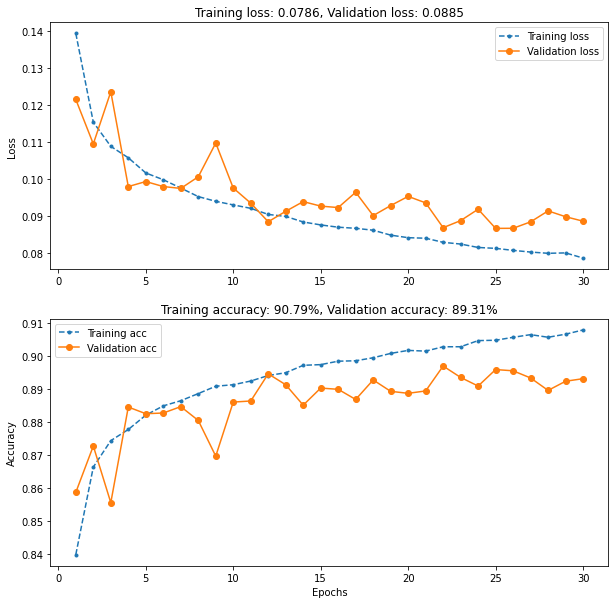

In [ ]:
plot_loss_acc(history)

In [30]:
path = "C:/Users/Lenovo/Documents/Paul/Travail/ENSEIRB-MATMECA/3A/Alpha-Go/alpha-go-like/priors/"
model.save('model_prior')

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

INFO:tensorflow:Assets written to: model_prior/assets
Saved model to disk


In [ ]:
def position_predict(black_stones, white_stones):

    X = np.zeros([1, board_size, board_size, 2], dtype = int)

    # Construction du board
    for white in white_stones:
        (col, lin) = name_to_coord(white)
        X[0][col][lin][1] = 1    
    for black in black_stones:
        (col, lin) = name_to_coord(black)
        X[0][col][lin][0] = 1

    prediction = model.predict(X)
    
    return prediction

In [ ]:
# Par exemple, nous pourrons appeler votre prédiction ainsi
print("Prediction this sample:")
P = np.random.randint(0, len(data))
prediction = position_predict(data[P]["black_stones"], data[P]["white_stones"])
reality = [data[P]["black_wins"]/data[P]["rollouts"], data[P]["white_wins"]/data[P]["rollouts"]]
print(f"For sample {P} you predicted {prediction} and the actual target was {reality}")

Prediction this sample:
For sample 15564 you predicted [[0.88326585 0.11933982]] and the actual target was [0.96, 0.04]


<font color="lightblue">

Il nous suffit maintenant d'appeler la fonction ```position_predict()``` pour calculer les prédictions des probabilités de victoire pour le joueur noir et le joueur blanc.

Le code suivant permettant de prédire les probabilités de victoire sur le jeu de données de base mais il est commenté car il est très long à exécuter et les résultats sont présentés par la suite.

</font>

# Prédictions des données

In [ ]:
# Importer les données à tester
# ------------ CHANGER ICI LES URLS -----------------
data_url = "https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz"
data_to_predict = "to_predict.json.gz"

data_url_results = "https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9-attempt.results.txt"
data_results = "results.txt"

to_predict = get_raw_data_go(data_url,data_to_predict)

'''
download(data_url_results,data_results)
# Récuperer les résults
with open("results.txt") as f:
    txt = f.readlines()
results = [float(x.strip()) for x in txt]
'''

File to_predict.json.gz not found, I am downloading it... Done


'\ndownload(data_url_results,data_results)\n# Récuperer les résults\nwith open("results.txt") as f:\n    txt = f.readlines()\nresults = [float(x.strip()) for x in txt]\n'

<font color="lightblue">

Nous pouvons maintenant écrire nos prédictions des nouvelles données dans ```my_predictions.txt```.

</font>

In [ ]:
# Prediction des données
predictions = np.empty(len(to_predict))

# Remplissage du tableau de prédictions
for t in range(len(to_predict)):
  # Comme nous souhaitons seulement les prédictions sur le % de victoire pour le joueur noir, on prend la première composante
  predictions[t] = position_predict(to_predict[t]['black_stones'], to_predict[t]['white_stones'])[0][0]

In [31]:
with open("my_predictions.txt", "w") as f:
     for p in predictions:
        f.write(str(p)+"\n")
print("Predictions saved")

Predictions saved
